# Data Preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the data from the CSV files
campaigns = pd.read_csv('/content/drive/MyDrive/Data - AtliqMart/dim_campaigns.csv')
products = pd.read_csv('/content/drive/MyDrive/Data - AtliqMart/dim_products.csv')
stores = pd.read_csv('/content/drive/MyDrive/Data - AtliqMart/dim_stores.csv')
fact_events = pd.read_csv('/content/drive/MyDrive/Data - AtliqMart/fact_events.csv')

# Display the first few rows of each dataframe
(campaigns.head(), products.head(), stores.head(), fact_events.head())

(   campaign_id campaign_name  start_date    end_date
 0  CAMP_DIW_01        Diwali  12-11-2023  18-11-2023
 1  CAMP_SAN_01     Sankranti  10-01-2024  16-01-2024,
   product_code                     product_name           category
 0          P01           Atliq_Masoor_Dal (1KG)  Grocery & Staples
 1          P02     Atliq_Sonamasuri_Rice (10KG)  Grocery & Staples
 2          P03          Atliq_Suflower_Oil (1L)  Grocery & Staples
 3          P04     Atliq_Farm_Chakki_Atta (1KG)  Grocery & Staples
 4          P05  Atliq_Scrub_Sponge_For_Dishwash          Home Care,
   store_id           city
 0  STTRV-0     Trivandrum
 1  STMDU-3        Madurai
 2  STHYD-6      Hyderabad
 3  STVSK-1  Visakhapatnam
 4  STCBE-3     Coimbatore,
   event_id store_id  campaign_id product_code  base_price    promo_type  \
 0   7f650b  STCBE-2  CAMP_SAN_01          P11         190       50% OFF   
 1   a21f91  STBLR-8  CAMP_DIW_01          P03         156       25% OFF   
 2   78bc80  STVJD-0  CAMP_SAN_01    

In [ ]:
# Join the tables on their respective keys
data = (
    fact_events.merge(campaigns, how="left", on="campaign_id")
              .merge(products, how="left", on="product_code")
              .merge(stores, how="left", on="store_id")
)

# Display the first few rows of the merged DataFrame
pd.set_option('display.max_columns', None)
data.head()

,event_id,store_id,campaign_id,product_code,base_price,promo_type,quantity_sold(before_promo),quantity_sold(after_promo),campaign_name,start_date,end_date,product_name,category,city
0,7f650b,STCBE-2,CAMP_SAN_01,P11,190,50% OFF,34,52,Sankranti,10-01-2024,16-01-2024,Atliq_Doodh_Kesar_Body_Lotion (200ML),Personal Care,Coimbatore
1,a21f91,STBLR-8,CAMP_DIW_01,P03,156,25% OFF,393,322,Diwali,12-11-2023,18-11-2023,Atliq_Suflower_Oil (1L),Grocery & Staples,Bengaluru
2,78bc80,STVJD-0,CAMP_SAN_01,P07,300,BOGOF,22,85,Sankranti,10-01-2024,16-01-2024,Atliq_Curtains,Home Care,Vijayawada
3,a1503f,STCBE-1,CAMP_DIW_01,P15,3000,500 Cashback,329,1000,Diwali,12-11-2023,18-11-2023,Atliq_Home_Essential_8_Product_Combo,Combo1,Coimbatore
4,1091cf,STBLR-6,CAMP_DIW_01,P05,55,25% OFF,108,93,Diwali,12-11-2023,18-11-2023,Atliq_Scrub_Sponge_For_Dishwash,Home Care,Bengaluru


In [ ]:
data['category'].value_counts()

category
Personal Care        400
Grocery & Staples    400
Home Care            400
Home Appliances      200
Combo1               100
Name: count, dtype: int64

# Primary Insights

## Store Performance

Before we begin, we need additional columns (i.e., revenue before, revenue after, amount sold, and total discount) to assist us in constructing the graph. So, let's start by calculating them.

In [ ]:
import pandas as pd

# a. Revenue Before --> To understand baseline performance.
data['revenue_before'] = data['base_price'] * data['quantity_sold(before_promo)']

# b. Quantity Sold --> Adjusts the quantity sold based on promotion type (e.g., doubling for BOGOF) to reflect actual sales impact.
data['quantity_sold'] = data.apply(
    lambda row: row['quantity_sold(after_promo)'] * 2 if row['promo_type'] == 'BOGOF' else row['quantity_sold(after_promo)'],
    axis=1
)

# c. Total Discount --> Computes the total discount amount applied to each sale to analyze the financial impact of promotions.
def calculate_discount(row):
    discount_rate = 0
    if row['promo_type'] == '25% OFF':
        discount_rate = 0.25
    elif row['promo_type'] == '50% OFF':
        discount_rate = 0.50
    elif row['promo_type'] == '33% OFF':
        discount_rate = 0.33
    elif row['promo_type'] == 'BOGOF':
        discount_rate = 0.50
    elif row['promo_type'] == '500 Cashback':
        return 500 * row['quantity_sold']
    return discount_rate * row['base_price'] * row['quantity_sold']

data['total_discount'] = data.apply(calculate_discount, axis=1)

# d. Actual Revenue --> Determines the actual revenue after accounting for discounts, providing a true measure of revenue.
data['actual_revenue'] = (data['base_price'] * data['quantity_sold']) - data['total_discount']

# Display the DataFrame with new calculated columns
pd.set_option('display.max_columns', None)
data.head()


,event_id,store_id,campaign_id,product_code,base_price,promo_type,quantity_sold(before_promo),quantity_sold(after_promo),campaign_name,start_date,end_date,product_name,category,city,revenue_before,quantity_sold,total_discount,actual_revenue
0,7f650b,STCBE-2,CAMP_SAN_01,P11,190,50% OFF,34,52,Sankranti,10-01-2024,16-01-2024,Atliq_Doodh_Kesar_Body_Lotion (200ML),Personal Care,Coimbatore,6460,52,4940.00,4940.00
1,a21f91,STBLR-8,CAMP_DIW_01,P03,156,25% OFF,393,322,Diwali,12-11-2023,18-11-2023,Atliq_Suflower_Oil (1L),Grocery & Staples,Bengaluru,61308,322,12558.00,37674.00
2,78bc80,STVJD-0,CAMP_SAN_01,P07,300,BOGOF,22,85,Sankranti,10-01-2024,16-01-2024,Atliq_Curtains,Home Care,Vijayawada,6600,170,25500.00,25500.00
3,a1503f,STCBE-1,CAMP_DIW_01,P15,3000,500 Cashback,329,1000,Diwali,12-11-2023,18-11-2023,Atliq_Home_Essential_8_Product_Combo,Combo1,Coimbatore,987000,1000,500000.00,2500000.00
4,1091cf,STBLR-6,CAMP_DIW_01,P05,55,25% OFF,108,93,Diwali,12-11-2023,18-11-2023,Atliq_Scrub_Sponge_For_Dishwash,Home Care,Bengaluru,5940,93,1278.75,3836.25


### Citywise Revenue Analysis

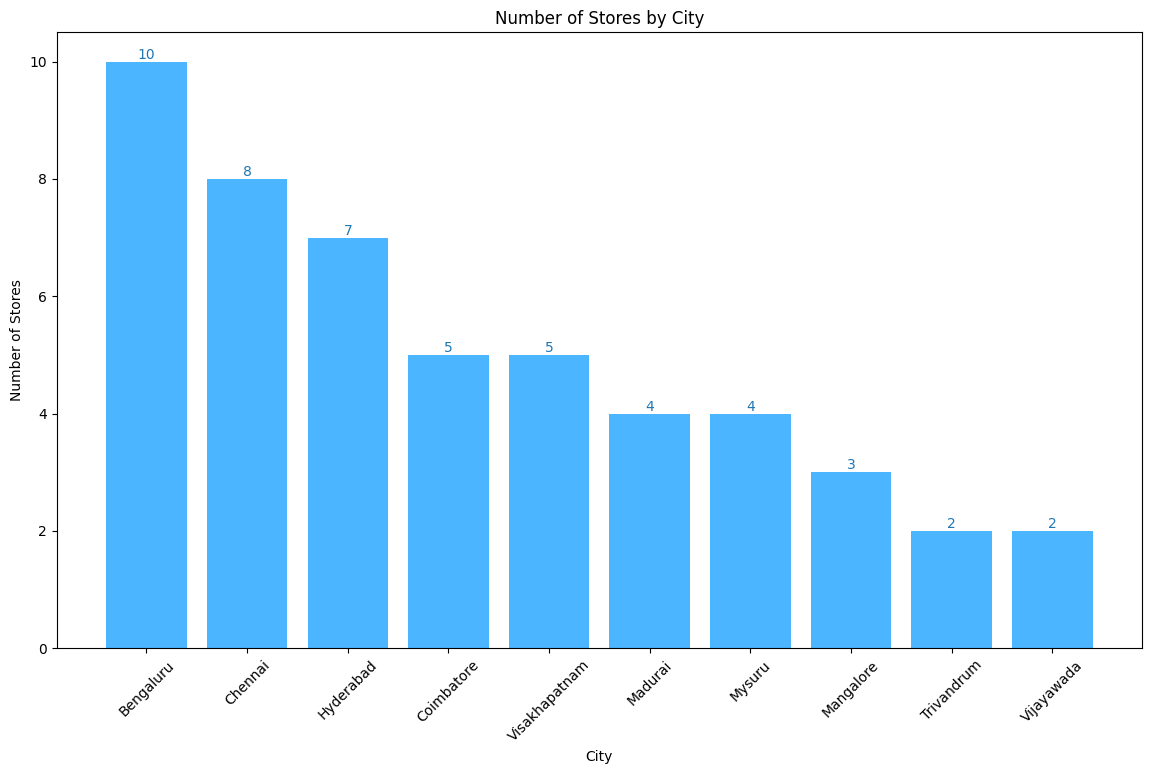

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of stores in each city
store_count = data.groupby('city')['store_id'].nunique().sort_values(ascending=False)

# Create a bar plot for the number of stores
plt.figure(figsize=(14, 8))
bars = plt.bar(store_count.index, store_count.values, color='#0096FF', alpha=0.7)

# Add labels to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', color='tab:blue', fontsize=10)

# Set title and labels
plt.title('Number of Stores by City')
plt.xlabel('City')
plt.ylabel('Number of Stores')

# Show the plot
plt.xticks(rotation=45)
plt.show()

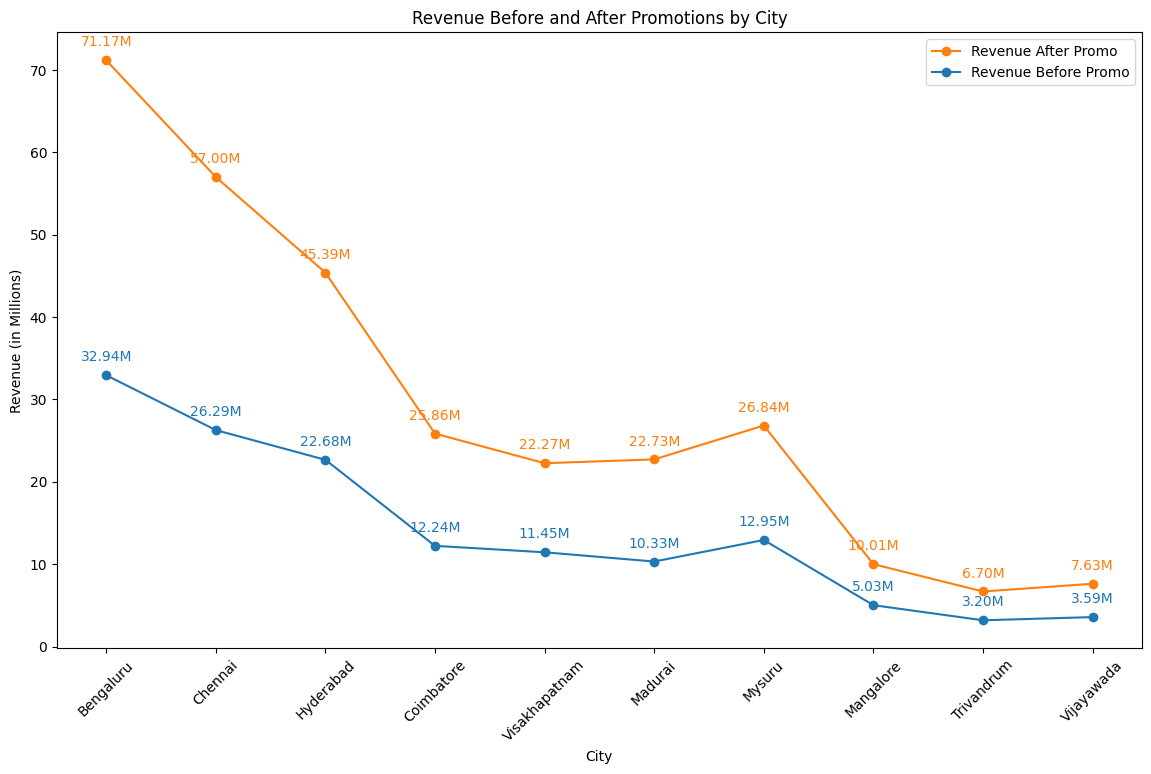

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of stores in each city
store_count = data.groupby('city')['store_id'].nunique().sort_values(ascending=False)

# Calculate total revenue before and after promotions for each city
revenue_before_city = data.groupby('city')['revenue_before'].sum() / 1_000_000  # Convert to millions
actual_revenue_city = data.groupby('city')['actual_revenue'].sum() / 1_000_000  # Convert to millions

# Sort revenues based on store count order
revenue_before_city = revenue_before_city.loc[store_count.index]
actual_revenue_city = actual_revenue_city.loc[store_count.index]

# Create a plot for the revenues
plt.figure(figsize=(14, 8))

# Plotting the actual revenue line chart
plt.plot(store_count.index, actual_revenue_city.values, color='tab:orange', marker='o', label='Revenue After Promo')

# Plotting the revenue before promotion line chart
plt.plot(store_count.index, revenue_before_city.values, color='tab:blue', marker='o', label='Revenue Before Promo')

# Adding labels to lines
for i, txt in enumerate(actual_revenue_city.values):
    plt.annotate(f'{txt:.2f}M', (store_count.index[i], actual_revenue_city.values[i]), textcoords="offset points", xytext=(0,10), ha='center', color='tab:orange')
for i, txt in enumerate(revenue_before_city.values):
    plt.annotate(f'{txt:.2f}M', (store_count.index[i], revenue_before_city.values[i]), textcoords="offset points", xytext=(0,10), ha='center', color='tab:blue')

# Adding legend
plt.legend(loc='upper right')

# Set title and labels
plt.title('Revenue Before and After Promotions by City')
plt.xlabel('City')
plt.ylabel('Revenue (in Millions)')

# Show the plot
plt.xticks(rotation=45)
plt.show()


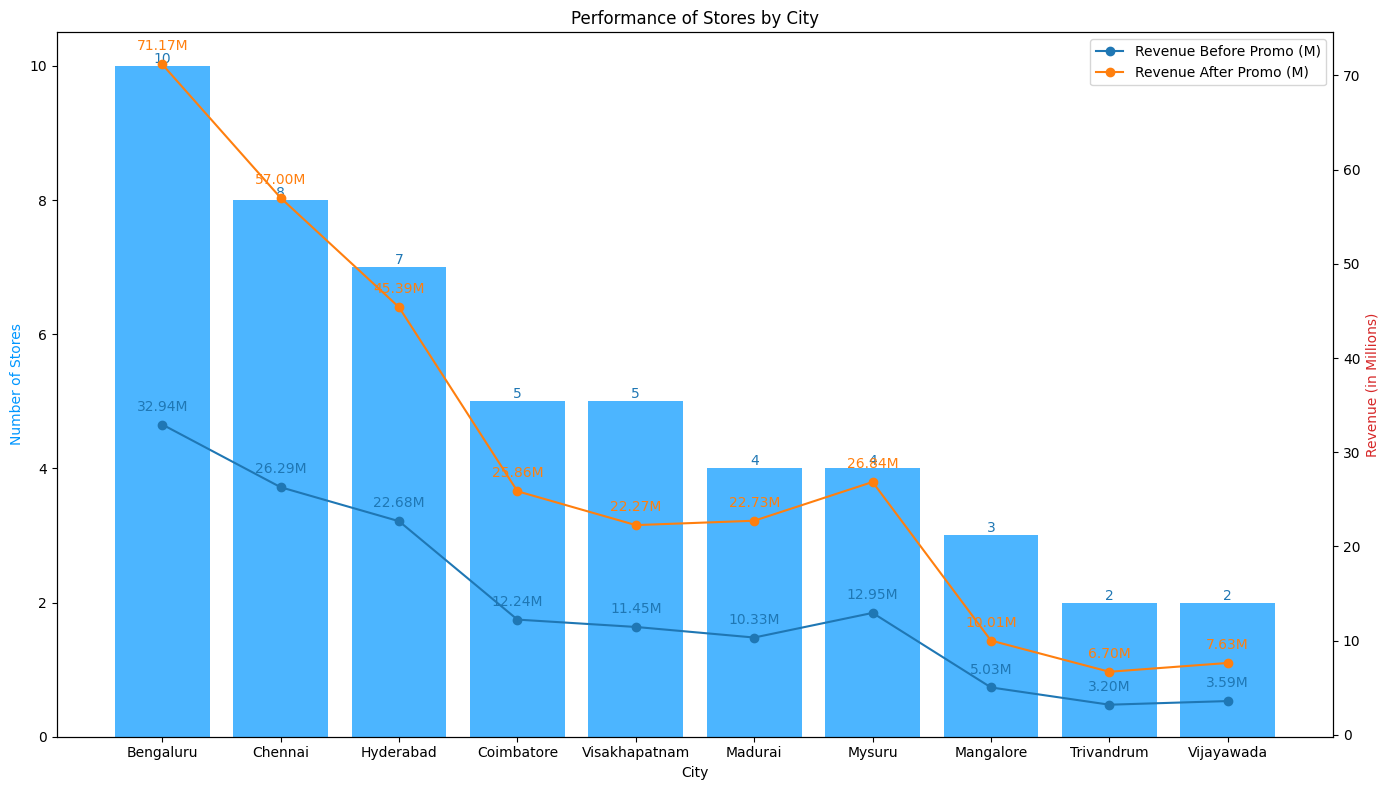

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of stores in each city
store_count = data.groupby('city')['store_id'].nunique().sort_values(ascending=False)

# Calculate total revenue before and after promotions for each city
revenue_before_city = data.groupby('city')['revenue_before'].sum() / 1_000_000  # Convert to millions
revenue_after_city = data.groupby('city')['actual_revenue'].sum() / 1_000_000   # Convert to millions

# Sort revenues based on store count order
revenue_before_city = revenue_before_city.loc[store_count.index]
revenue_after_city = revenue_after_city.loc[store_count.index]

# Create a bar plot for the number of stores
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('City')
ax1.set_ylabel('Number of Stores', color='#0096FF')  # Cobalt blue shade
bars = ax1.bar(store_count.index, store_count.values, color='#0096FF', alpha=0.7, label='Number of Stores')

# Add labels to bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', color='tab:blue', fontsize=10)

# Create a line plot for revenue before and after promotions
ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis
ax2.set_ylabel('Revenue (in Millions)', color='tab:red')

line1, = ax2.plot(revenue_before_city.index, revenue_before_city.values, color='tab:blue', marker='o', label='Revenue Before Promo (M)')
line2, = ax2.plot(revenue_after_city.index, revenue_after_city.values, color='tab:orange', marker='o', label='Revenue After Promo (M)')

# Add labels to lines
for i, txt in enumerate(revenue_before_city.values):
    ax2.annotate(f'{txt:.2f}M', (revenue_before_city.index[i], revenue_before_city.values[i]), textcoords="offset points", xytext=(0,10), ha='center', color='tab:blue')
for i, txt in enumerate(revenue_after_city.values):
    ax2.annotate(f'{txt:.2f}M', (revenue_after_city.index[i], revenue_after_city.values[i]), textcoords="offset points", xytext=(0,10), ha='center', color='tab:orange')

# Adding legend
lines = [line1, line2]
ax2.legend(lines, [l.get_label() for l in lines], loc='upper right')

# Title and labels
plt.title('Performance of Stores by City')
fig.tight_layout()  # to ensure the right y-label is not slightly clipped

# Show the plot
plt.show()

**What we understood:** The visualization shows the performance of stores by city, indicating the number of stores in each city (bars) and comparing the revenue before and after promotions (line charts). It is evident that Bengaluru, with the highest number of stores, generates the highest revenue both before and after promotions. In contrast, cities with fewer stores like Trivandrum and Vijayawada have significantly lower revenues. This suggests that store count positively correlates with revenue, and promotional activities generally increase revenue across all cities.

### Store Metrices Overview

In [ ]:
import pandas as pd

# Calculate Incremental Sold Units (ISU)
data['Incremental Sold Units (ISU)'] = data['quantity_sold(after_promo)'] - data['quantity_sold(before_promo)']

# Calculate Incremental Sold Units (ISU) %
data['Incremental Sold Units (ISU) %'] = (data['Incremental Sold Units (ISU)'] / data['quantity_sold(before_promo)']) * 100

# Sort by quantity_sold(after_promo) in descending order
sorted_data = data.sort_values(by='quantity_sold(after_promo)', ascending=False)

# Select the relevant columns
result = sorted_data[['store_id', 'city', 'quantity_sold(before_promo)', 'quantity_sold(after_promo)', 'Incremental Sold Units (ISU)', 'Incremental Sold Units (ISU) %']]

# Display the result
result

,store_id,city,quantity_sold(before_promo),quantity_sold(after_promo),Incremental Sold Units (ISU),Incremental Sold Units (ISU) %
687,STCHE-2,Chennai,513,2067,1554,302.923977
876,STBLR-0,Bengaluru,465,2064,1599,343.870968
1394,STMYS-1,Mysuru,450,1984,1534,340.888889
596,STCHE-6,Chennai,483,1907,1424,294.824017
492,STHYD-2,Hyderabad,472,1902,1430,302.966102
...,...,...,...,...,...,...
1144,STVJD-1,Vijayawada,16,11,-5,-31.250000
1422,STMLR-1,Mangalore,13,10,-3,-23.076923
1216,STMLR-1,Mangalore,13,10,-3,-23.076923
867,STVJD-1,Vijayawada,13,9,-4,-30.769231


### Category Sales Dynamics

In [ ]:
diff_category = data['category'].value_counts()
diff_category

category
Personal Care        400
Grocery & Staples    400
Home Care            400
Home Appliances      200
Combo1               100
Name: count, dtype: int64

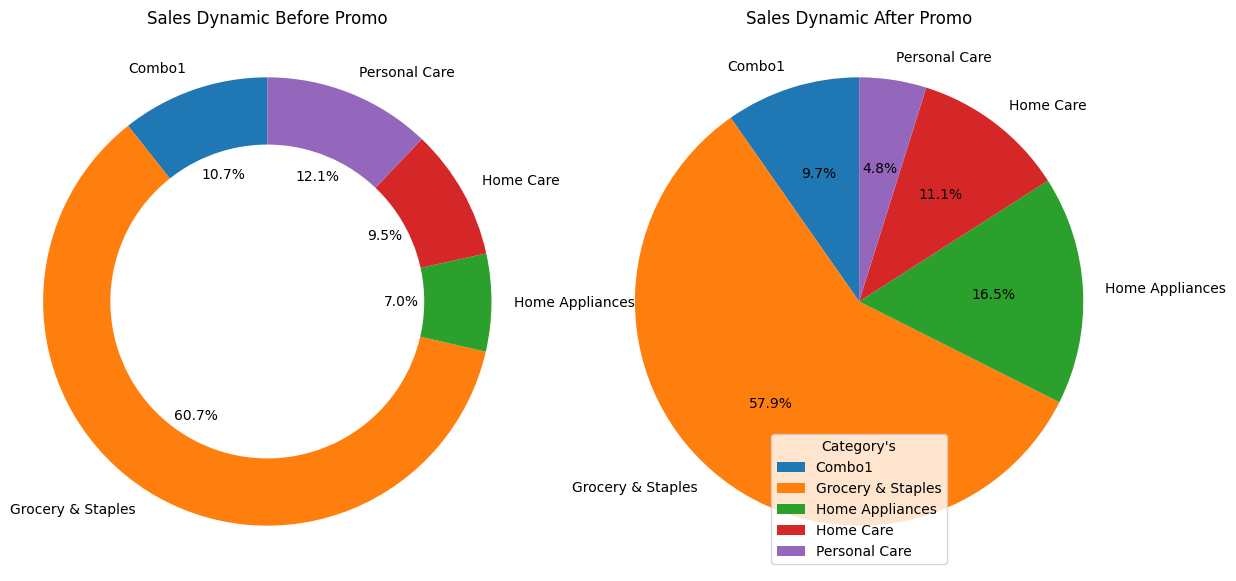

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Use value_counts to count occurrences of each category for before and after quantity
category_counts_before = data.groupby('category')['quantity_sold(before_promo)'].sum()
category_counts_after = data.groupby('category')['quantity_sold'].sum()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Donut chart for quantity before
axs[0].pie(category_counts_before, labels=category_counts_before.index, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[0].add_artist(centre_circle)
axs[0].set_title('Sales Dynamic Before Promo')

# Pie chart for quantity after
axs[1].pie(category_counts_after, labels=category_counts_after.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Sales Dynamic After Promo')

# Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].axis('equal')
axs[1].axis('equal')

plt.legend(category_counts_before.index, title="Category's", loc= "lower center")
plt.show()

## Finance

### Revenue Trends by Stores

In [ ]:
import pandas as pd

# Assuming 'data' is your DataFrame
table_data = {
    'Store ID': data['store_id'],
    'Qty Before': data['quantity_sold(before_promo)'],
    'Qty After': data['quantity_sold'],
    'Revenue Before': data['revenue_before'],
    'Revenue After': data['actual_revenue'],
    'IR': (data['quantity_sold'] - data['quantity_sold(before_promo)']),
    'IR %': ((data['quantity_sold'] - data['quantity_sold(before_promo)']) / data['quantity_sold(before_promo)']) * 100,
    'ISU': (data['actual_revenue'] - data['revenue_before']),
    'ISU %': ((data['actual_revenue'] - data['revenue_before']) / data['revenue_before']) * 100
}

# Create DataFrame from table_data
table_df = pd.DataFrame(table_data)

# Display the table
table_df

,Store ID,Qty Before,Qty After,Revenue Before,Revenue After,IR,IR %,ISU,ISU %
0,STCBE-2,34,52,6460,4940.00,18,52.941176,-1520.00,-23.529412
1,STBLR-8,393,322,61308,37674.00,-71,-18.066158,-23634.00,-38.549618
2,STVJD-0,22,170,6600,25500.00,148,672.727273,18900.00,286.363636
3,STCBE-1,329,1000,987000,2500000.00,671,203.951368,1513000.00,153.292806
4,STBLR-6,108,93,5940,3836.25,-15,-13.888889,-2103.75,-35.416667
...,...,...,...,...,...,...,...,...,...
1495,STBLR-3,61,84,3782,2604.00,23,37.704918,-1178.00,-31.147541
1496,STMDU-1,22,18,1100,675.00,-4,-18.181818,-425.00,-38.636364
1497,STCBE-0,80,119,4960,3689.00,39,48.750000,-1271.00,-25.625000
1498,STVSK-0,73,564,25550,98700.00,491,672.602740,73150.00,286.301370


### Promotype Frequency

In [ ]:
import plotly.graph_objects as go

# Assuming 'data' is your DataFrame
# Use value_counts to count occurrences of each promo type
promo_counts = data['promo_type'].value_counts()

# Create a waterfall chart
fig = go.Figure(go.Waterfall(
    orientation = "v",
    measure = ["relative"] * len(promo_counts) + ["total"],
    x = promo_counts.index.tolist() + ["Total"],
    y = promo_counts.tolist() + [promo_counts.sum()],
    textposition = "outside",
    text = ["+{}".format(val) for val in promo_counts.tolist()] + ["Total"],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
    title = "Promotype Frequency",
    xaxis_title = "Promo Type",
    yaxis_title = "Frequency",
    showlegend = False
)

fig.show()

### Product Performance by Campaign and Promotion

In [ ]:
import pandas as pd

# Assuming 'data' is your DataFrame
table_data = {
    'Product Name': data['product_name'],
    'Campaign Name': data['campaign_name'],
    'Promo Type': data['promo_type'],
    'Qty Sold': data['quantity_sold'],
    'Revenue': data['actual_revenue'],
    'IR%': ((data['quantity_sold'] - data['quantity_sold(before_promo)']) / data['quantity_sold(before_promo)']) * 100,
    'ISU%': ((data['actual_revenue'] - data['revenue_before']) / data['revenue_before']) * 100
}

# Create DataFrame from table_data
table_df = pd.DataFrame(table_data)

# Display the table
table_df

,Product Name,Campaign Name,Promo Type,Qty Sold,Revenue,IR%,ISU%
0,Atliq_Doodh_Kesar_Body_Lotion (200ML),Sankranti,50% OFF,52,4940.00,52.941176,-23.529412
1,Atliq_Suflower_Oil (1L),Diwali,25% OFF,322,37674.00,-18.066158,-38.549618
2,Atliq_Curtains,Sankranti,BOGOF,170,25500.00,672.727273,286.363636
3,Atliq_Home_Essential_8_Product_Combo,Diwali,500 Cashback,1000,2500000.00,203.951368,153.292806
4,Atliq_Scrub_Sponge_For_Dishwash,Diwali,25% OFF,93,3836.25,-13.888889,-35.416667
...,...,...,...,...,...,...,...
1495,Atliq_Lime_Cool_Bathing_Bar (125GM),Sankranti,50% OFF,84,2604.00,37.704918,-31.147541
1496,Atliq_Cream_Beauty_Bathing_Soap (125GM),Sankranti,25% OFF,18,675.00,-18.181818,-38.636364
1497,Atliq_Lime_Cool_Bathing_Bar (125GM),Diwali,50% OFF,119,3689.00,48.750000,-25.625000
1498,Atliq_High_Glo_15W_LED_Bulb,Sankranti,BOGOF,564,98700.00,672.602740,286.301370


### Sales Distribution by Category

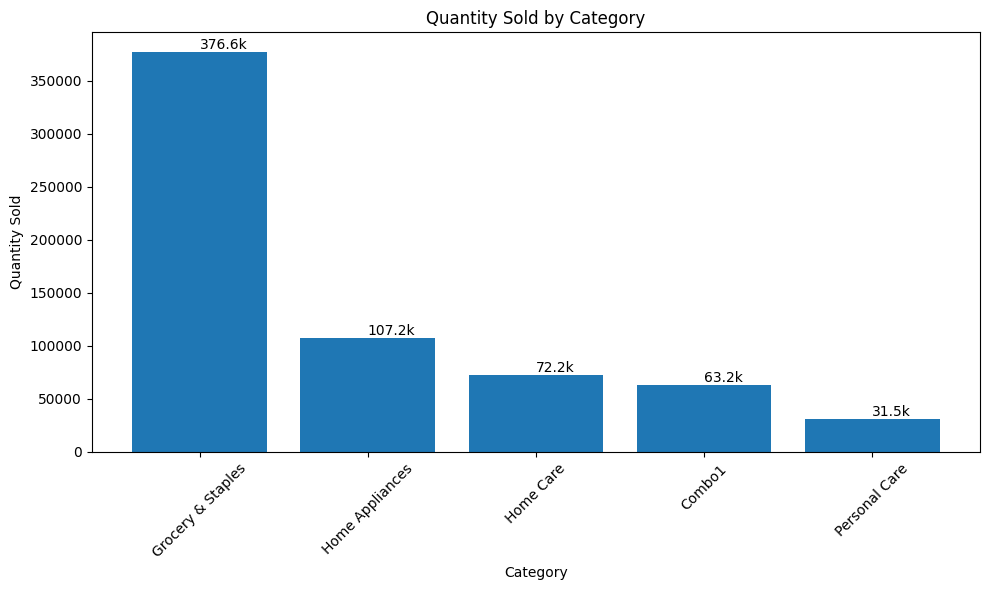

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Group by category and sum the quantity sold
category_qty = data.groupby('category')['quantity_sold'].sum()

# Sort categories by quantity sold
category_qty_sorted = category_qty.sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(category_qty_sorted.index, category_qty_sorted.values)

# Add labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval/1000:.1f}k', va='bottom')

# Customize the plot
plt.xlabel('Category')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold by Category')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Revenue Distribution by Category


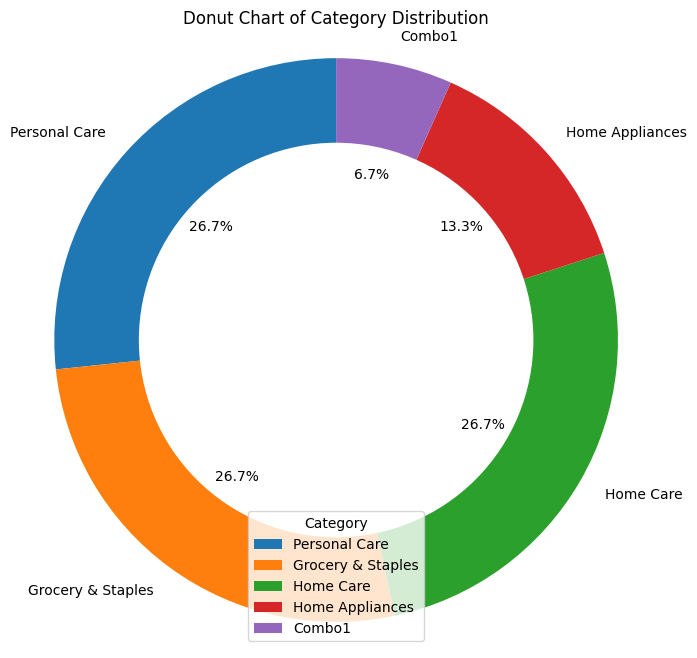

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Use value_counts to count occurrences of each category
category_counts = data['category'].value_counts()

# Create a donut chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

plt.title('Donut Chart of Category Distribution')
plt.legend(category_counts.index, title="Category", loc = "lower center")
plt.show()